In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from EnvLibs import Environment, RewardKernel, TrafficGenerator

In [2]:
def PolicyDemoFixed(u, params):
    alpha = 0.2
    w = typeAllocator(u, params['LEN_window'])
    r = np.floor(alpha*params['B'])/(np.sum(w)+1e-10) * w
    M = 3
    return w, r, M, alpha

def PolicyDemoAdaptiveAlpha(u, params): 
    rewardKernel = RewardKernel(params)
    w = typeAllocator(u, params['LEN_window'])
    M = 3 
    alphaList = np.linspace(0.01, 1.0, 100)
    JmdpRecord = []
    for alpha in alphaList:
        r = np.floor(alpha*params['B'])/(np.sum(w)+1e-10) * w 
        Jmdp = rewardKernel.getReward(u, w, r, M, alpha)
        JmdpRecord.append(Jmdp)
    alpha = alphaList[np.argmin(JmdpRecord)]
    r = np.floor(alpha*params['B'])/(np.sum(w)+1e-10) * w
    return w, r, M, alpha

def typeAllocator(u, lEN_window):
    w = (u>int(lEN_window*0.5)).astype(int)
    return w

In [3]:
class Simulator:
    def __init__(self, params, trafficGenerator):
        self.params = params
        self.trafficGenerator = trafficGenerator
    
    def runSimulation(self, policy, num_epochs=1000, mode="test", type="data"):
        """
        Run simulation with a given policy function
        
        Args:
            policy_func: Function that takes (u, params) and returns (w, r, M, alpha) as action
            params: Dictionary of parameters
            num_epochs: Number of simulation epochs (default: 1000)
        
        Returns:
            rewardRecord: List of rewards for each epoch
        """
        env = Environment(self.params, self.trafficGenerator)
        env.selectMode(mode=mode, type=type)
        rewardRecord = []
        alphaRecord = []
        for epoch in range(num_epochs):
            u = env.updateStates()
            (w, r, M, alpha) = policy(u, self.params)
            reward = env.applyActions(np.array(w), np.array(r), M, alpha)
            rewardRecord.append(reward)
            alphaRecord.append(alpha)
        
        return rewardRecord, alphaRecord, env

Ts:0.001, Size: (10056,)
Ts:0.001, Size: (10343,)
Ts:0.001, Size: (10285,)
avgPacketLossRate_fixed: 0.052442318925233544, avgPacketLossRate_adaptive: 0.03346037540036138


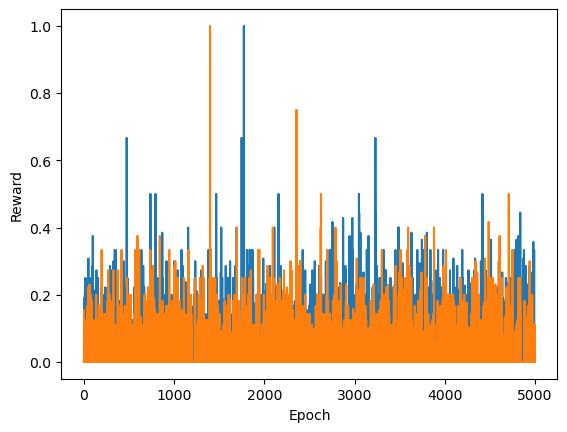

In [4]:
params = {
    'N_user': 4,
    'LEN_window': 10,
    'r_bar': 4,
    'B': 40,
    'randomSeed': 999,
}

dataFlow = "thumb_fr"
trafficGenerator = TrafficGenerator(params)
for userType in range(3):
    with open(f'Results/TrafficData/trafficData_{userType}_{dataFlow}.pkl', 'rb') as f:
        trafficData = pickle.load(f)
    trafficGenerator.registerDataset(trafficData['traffic'], train_ratio=0.7)
    print(f"Ts:{trafficData['Ts']}, Size: {trafficData['traffic'].shape}")

simulator = Simulator(params, trafficGenerator)

rewardRecord_fixed, alphaRecord_fixed, env_fixed = simulator.runSimulation(PolicyDemoFixed, num_epochs=5000, mode="test", type="data")
rewardRecord_adaptive, alphaRecord_adaptive, env_adaptive = simulator.runSimulation(PolicyDemoAdaptiveAlpha, num_epochs=5000, mode="test", type="data")
avgPacketLossRate_fixed = env_fixed.getPacketLossRate()
avgPacketLossRate_adaptive = env_adaptive.getPacketLossRate()
print(f"avgPacketLossRate_fixed: {avgPacketLossRate_fixed}, avgPacketLossRate_adaptive: {avgPacketLossRate_adaptive}")

plt.plot(rewardRecord_fixed)
plt.plot(rewardRecord_adaptive)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.show()